# Question 1: Project on ARC - Classifying images in the CIFAR10 dataset

We would like to classify some images from the CIFAR10 dataset, with the data in the form $(x_i, y_i)$ with $x_i \in \mathbb{R}^{d\times d}$ ($d=32$) being the images that corresponds to one of the ten objects $y_i \in \mathbb{R}^K$ ($K=10$). In homework #2 you have implemented a deep convolutional neural network with the architecture specified on page 81-82 of slides for lectures 4-6, and we will study how different hyper-parameters affect the training performances.

> **Important Note:** The notebook here is only a supplement. 
> - All files for this question (`HW3_main.py`, `HW3_method.py`, `Homework_#3_Q1.ipynb`) should be uploaded on the same directory in your ARC cluster `$DATA` directory or your Google Colab.
> - You should *avoid* using GPU to run this Jupyter notebook.
> - The training in part (d) and evaluation in part (f) should be done by *submitting* to the ARC cluster. You should **NOT** use the interactive ARC node. 
> - You can use the example codes to complete part (e).

## Part (a) - saving your model and training logs
- Explain how the train method saves the model parameters and training accuracies. 
- Why do we format the name of files for model parameters and training accuracies in a particular way?
**Note:** You can also store the training accuracies as an attribute to the model, and you are more than free to do so by editing relevant codes in `HW3_methods.py`.)

### <span style="color:red">You can edit this cell to fill in your answer of part (a).</span>

## Part (b) - editing `HW3_main.py` and `HW3_methods.py` to make them ARC cluster ready

In the [ARC cluster guide](https://courses.maths.ox.ac.uk/pluginfile.php/103104/mod_resource/content/6/ARC_tutorial_v3.pdf), you have learned about how one could specify parameters in the `config.txt` file and pass them onto the Python script. 

Complete the codes in HW3_main.py so that the file now parses our parameters (`dropout`, `n_channels`, `lr`) and pass them to the methods in HW3_methods.py.

Remember, you have to
- first use `argparse` function to define the parameters, and then
- use the `args` object to pass the parameters to the relevant methods/objects.

Once finished, you can run the following cell to test the code. You might want to reduce the number of epochs.


In [ ]:
# enable autoreload
%load_ext autoreload
%autoreload 2

: 

In [ ]:
%run ./HW3_main.py --dropout 0.8 \
  --n_channels 64 \
  --lr 0.005 \
  --device cpu \
  --num_epochs 5 \
  --print_freq 1

Files already downloaded and verified
Files already downloaded and verified
dropout=0.8, n_channels=64, lr=0.005, device=cuda


Training ConvNet with dropout proba=0.8, numbers of channels=64 and learning rate=0.005.
In epoch  1  the accuracy of the training set = 20.244

Time to train the model: 2.475891288121541 mins.
Accuracy on the test set =  21.61
mean test accuracy = 21.61%.


## Part (c) - training in ARC
Please refer to the homework assignment. Do not train your actual model here.

## Part (d) - simple post-processing
Congratulations! You have now completed all the training. Let us perform some analysis on our training result. To plot the figures, you may wish to check your files in your directory by using the usual `ls` command.

In [ ]:
%ls

: 

For part (1), you may plot the training accuracy versus the training time for different parameter values.

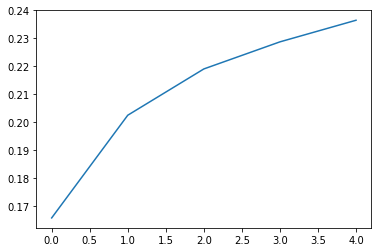

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# You should have training accuracies for at least four models.
# You can load the training accuracies using the following code.
# Remember to change to file path.
df = pd.read_csv("./train_accuracies_n_channels_64_dropout_0.8_lr_0.005.csv")

# You may plot all training accuracies in one plot, or organise them in a few subplots.
plt.plot(df["0"] / 100)

To complete part (2) and (3), you should load the test dataset.

2. Generate a scatter plot/heatmap that compare the test accuracies for different choices for hyperparameters,

3. Display some of the images from the CIFAR10 dataset and investigate which types of images the best model (as found in part (a)) is able to correctly classify and which images this model incorrectly classifies (refer to the last part of question 2 in the previous assignment). For this, you should upload your model, then run the following cell.

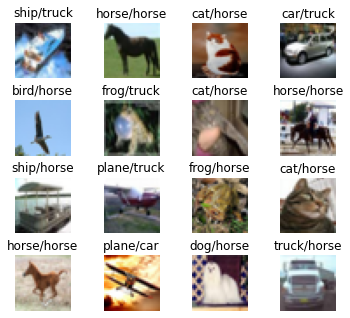

In [23]:
import HW3_methods, torch, torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np

# load your model
model = HW3_methods.CIFAR10Model(10,.8,64) # modify the hyper-parameter accordingly
model.load_state_dict(torch.load("./model_n_channels_64_dropout_0.8_lr_0.005"))

# test your model
X_train = torchvision.datasets.CIFAR10(root='./CIFARdata', train=True, download=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog','frog', 'horse', 'ship', 'truck')

# Predictions
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

# setting the figure parameters
num_row = 4
num_col = 4 # to get 4 * 4 = 16 images together
imageId = np.random.randint(0, len(X_train), num_row * num_col)
fig, axes = plt.subplots(num_row, num_col)
for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        img, target = X_train[imageId[k]]
        pred = torch.argmax(model(normalize(transforms.ToTensor()(img)).unsqueeze(dim=0)))
        axes[i,j].imshow(img)
        axes[i,j].set_title(classes[target] + "/" + classes[pred])
        axes[i,j].axis('off')
        
plt.subplots_adjust(left=0.1, bottom=0.0,  
                    right=0.9, top=1.0,  
                    wspace=0.1, hspace=0.4) 

## Part (e) - Monte Carlo

For this part, complete the code of the function `test_eval`. You can then run the experiment using this notebook, or create suitable Python files + bash script for submission to ARC.

In [25]:
# load the dataset first
_, data_test = HW3_methods.load_data(batch_size=100)

# TODO: complete the function
def test_eval(model, heuristic, n_samples, batch_size=100):
    '''
    model is the trained CNN model object.
    If heuristic == True then return heuristic estimator, otherwise return Monte Carlo estimator.
    n_samples is the number of CNNs to be sampled for the Monte Carlo estimator.
    We assume that you are running this function with GPU. 
    You should remove the .cuda() method if you are running this code locally without GPU.
    '''

    test_accuracy = []
    
    model.cuda()

    assert not heuristic or n_samples > 1

    if heuristic:
        model.eval()

    with torch.no_grad():
        for batch in data_test:
            data, target = batch
            data, target  = Variable(data).cuda(), Variable(target).cuda()

            # TODO: compute the average outputs of the CNN outputs

            # TODO: make prediction on this batch based on the average outputs

            # TODO: compute the accuracy of the prediction on this batch
            accuracy = None

            # TODO: store test accuracy for this batch
            test_accuracy.append(accuracy)

    # return test accuracies averaged across batches
    return np.mean(test_accuracy)

Files already downloaded and verified
Files already downloaded and verified


Then run the following code snippets for the experiment.

In [27]:
# Code snippet for the experiment (if you are running using your local computer).
# You can parallelise the experiment accordingly by creating suitable submission 
# bash scripts with config.txt file.

# load your model
# modify the hyper-parameter accordingly
model = HW3_methods.CIFAR10Model(10,.8,64)

# load the parameter dictionary
model.load_state_dict(torch.load("./model_n_channels_64_dropout_0.8_lr_0.005"))

n_runs = 10
range_n_samples = [5, 10, 20, 40, 80]
mc_test_acc = np.zeros((5, n_runs))
model.cuda()

for k, n_samples in enumerate(range_n_samples):
    for j in range(n_runs):
        mc_test_acc[k, j] = test_eval(False, n_samples)

8it [24:32, 184.02s/it]


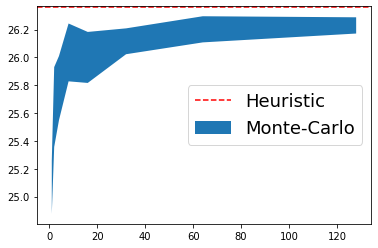

In [28]:
# postprocessing

y = np.mean(mc_test_acc, axis=1)
error = np.std(mc_test_acc, axis=1)
plt.fill_between(range_n_samples, y-error, y+error,  label="Monte-Carlo")
plt.axhline(y = test_eval(True, n_samples), color = 'red', linestyle = '--', label="Heuristic") 
plt.legend(loc="center right", fontsize=18)
plt.show()